In [216]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True) # para usar latex en matplotlib

In [146]:
def A(un, a, b, domain, dim):
    kappa = 0
    
    cache_norm_grad = {}
    def norm_grad(un, p):
        ix = domain.index(p)
        if ix not in cache_norm_grad.keys():
            dx = 0
            dy = 0
            if p[1]<dim[1]-1:
                kx = domain.index((p[0], p[1]+1))
                dx = un[kx]-un[ix]
            if p[0]<dim[0]-1:
                kx = domain.index((p[0]+1, p[1]))
                dy = un[kx]-un[ix]
                
            val = np.sqrt( dx**2 + dy**2 )  
            cache_norm_grad[ix] = val
        return cache_norm_grad[ix]
    
    cache_harmonic_mean = {}
    def harmonic_mean(un, p, m):
        ix = domain.index(p)
        jx = domain.index(m)
        if (ix, jx) not in cache_harmonic_mean.keys():
            cache_harmonic_mean[(ix, jx)] = 2 / ( (norm_grad(un, p)/b[ix]) + (norm_grad(un, m)/b[jx]) )
        return cache_harmonic_mean[(ix, jx)]
        
    
    def neighbours(p, l="x"):
        px, py = p
        
        if l == "x":
            o = [ (px, py-1), (px, py+1) ]
            
        elif l == "y":
            o = [ (px-1, py), (px+1, py) ]
            
        return [m  for m in o if m in domain]
    
    def get_sigma(p):
        norm_grad_p = norm_grad(un, p)
        ix = domain.index(p)
        if np.isclose(norm_grad_p, 0):
            return 0
        else:
            sum_N = sum( harmonic_mean(un, p, m) for m in neighbours(p, l="x") + neighbours(p, l="y") )
            return - a[ix] * norm_grad_p * sum_N
    
    def get_delta(p, m):
        norm_grad_p = norm_grad(un, p)
        ix = domain.index(p)
        if np.isclose(norm_grad_p, 0):
            return 0
        else:
            return - a[ix] * norm_grad_p * harmonic_mean(un, p, m)
    
    def get_A_row(row):
        px = row
        
        D = [ get_sigma( (px, c) ) for c in range( dim[1] ) ]                 # 0,1,...,c-2,c-1
        D1 = [ get_delta( (px, c), (px, c+1) ) for c in range( dim[1] - 1 ) ] # 0,1,...,c-2
        D_1 = [ get_delta( (px, c), (px, c-1) )  for c in range(1, dim[1] ) ] #   1,...,c-2,c-1
    
        
        k = np.array([D_1, D, D1], dtype= object)
        offset = [-1, 0, 1]
        
        return diags(k, offset)
    
    def get_A_star_row(row, star):
        px = row
        
        D = [ get_delta( (px, c), (px+star, c) ) for c in range( dim[1] ) ]
        
        k = D
        offset = 0
        
        return diags(k, offset)
    
    D = [ get_A_row(row) for row in range( dim[0] ) ]                                                     # 0,1,...,c-2,c-1
    D1 =  [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=1) for row in range( dim[0] - 1 ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))] # 0,1,...,c-2
    D_1 = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=-1) for row in range(1, dim[0] ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]  #   1,...,c-2,c-1

    A0 = block_diag(D)
    A1 = csr_matrix(block_diag(D1).todense()[dim[1]:,:-dim[1]])
    A2 = csr_matrix(block_diag(D_1).todense()[:-dim[1],dim[1]:])

    return csr_matrix(A0+A1+A2)
    

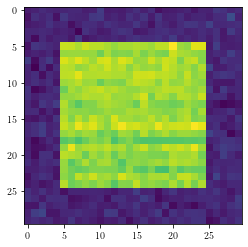

In [215]:
dim = (30, 30)
domain = [ 
    (x, y) for x in range( dim[0] ) for y in range( dim[1] )
]

img = np.random.normal(0.4, 0.005, size=dim[0] * dim[1])
for i in range(dim[0]//2+5):
    img[dim[0]*(i+5)+5:dim[0]*(i+6)-5] += np.random.normal(0.1, 0.005)

a = np.ones(dim[0] * dim[1])
b = np.ones(dim[0] * dim[1])

display(plt.imshow(img.reshape(dim[0], dim[1])))

In [383]:
def level_set(x0, r, domain, dim):
    u0 = np.zeros(len(domain))
    for p in domain:
        x = (p[0]/(dim[0]-1), p[1]/(dim[1]-1))
        sgn = 0
        if (x[0]-x0[0]) ** 2 + (x[1]-x0[1]) ** 2 < r ** 2:
            sgn = 1
        else:
            sgn = -1
        dist = abs(r-linalg.norm([x[0]-x0[0], x[1]-x0[1]]))
        ix = domain.index(p)
        u0[ix] = sgn * dist
    return u0

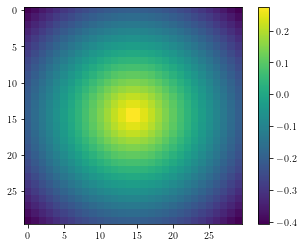

In [384]:
u0 = level_set((0.5, 0.5), 0.3, domain, dim)
plt.imshow(u0.reshape(dim[0], dim[1]))
plt.colorbar()

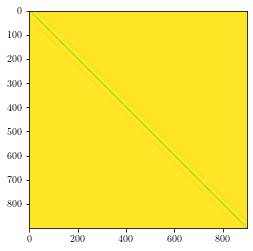

In [385]:
A0 = A(u0, a, b, domain, dim)
display(plt.imshow(An.todense()))

In [234]:
def A_tilde(un, a, b, domain, dim, tau):
    An = A(un, a, b, domain, dim)
    print(un.shape)
    I = csr_matrix(np.eye(un.shape[0]))
    return I - tau * An

(900,)


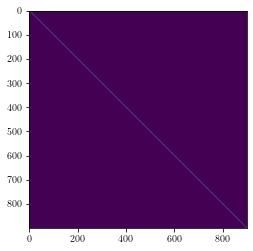

In [386]:
tau = 0.1
A0_tilde = A_tilde(u0, a, b, domain, dim, tau)
display(plt.imshow(A0_tilde.todense()))

In [406]:
un = u0

(900,)


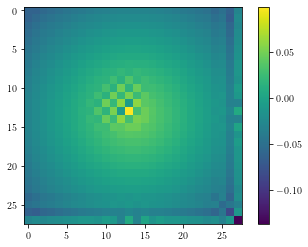

In [409]:
An_tilde = A_tilde(un, a, b, domain, dim, tau)
un1 = spsolve(An_tilde, un)
# un1[(un1<0.01) & (un1>-0.01)] = 1
plt.imshow(un1.reshape(dim[0], dim[1])[1:-1, 1:-1])
plt.colorbar()
un = un1